In [97]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
import DCTools as DCTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import lsst.daf.base as dafBase

import lsst.afw.math as afwMath

import glob
from astropy.io import ascii

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

from lsst.afw.fits import FitsError

from astropy.table import Column

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

In [80]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Production"
directory = DATADIR+"/detect_prod/"
butler = dafPersist.Butler(directory) 

In [183]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()


In [96]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

def detect_sources(diffExp, threshold):
    
        algMetadata = dafBase.PropertyList()
        schema = afwTable.SourceTable.makeMinimalSchema()
        dipoleMeasurement = DipoleMeasurementTask

        config = dipoleMeasurement.ConfigClass()
        sigma = threshold
        dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)

        source_catalog = None
        classification = []

        #diffExp = sensorRef.get("dayDiff_differenceExp")

        #print sigma
        results = DSTools.detect_diasources(diffExp, doSmooth=True, threshold=sigma)
        try:
            diaSources =  DCTools.merge_sources(results, schema, algMetadata)
            dipoleMeasurement.run(diaSources, diffExp)
            #print len(diaSources)
            #print source_catalog
            source_catalog = DCTools.remove_nan_sources(diaSources)
            #print len(source_catalog)
        except Exception, e:
             print "exception", e
                
        if source_catalog is None:
           # classification =  [str(visit)+"-"+str(ccd)]
           classification = [None]


        return source_catalog

In [6]:
from datetime import *

di = "2004-01-01"
df = "2004-07-30"
days = []

dates = butler.queryMetadata("calexp", format="date", dataid={'filter':'r'})

first_date = datetime.strptime(di, "%Y-%m-%d")
final_date = datetime.strptime(df, "%Y-%m-%d")



for date in  dates:
        if datetime.strptime(date,"%Y-%m-%d" )<final_date and datetime.strptime(date, "%Y-%m-%d")>first_date:

            days.append(date)

In [74]:
mjds_dict = {}
for day in days:
    t = Time(day)
    mjds_dict[t.mjd] = day
    

In [73]:
days

['2004-03-16',
 '2004-03-19',
 '2004-03-17',
 '2004-04-26',
 '2004-04-14',
 '2004-05-09',
 '2004-04-17',
 '2004-05-21',
 '2004-05-26',
 '2004-05-13',
 '2004-05-24',
 '2004-04-28',
 '2004-06-09',
 '2004-04-22',
 '2004-03-30',
 '2004-04-21',
 '2004-06-13',
 '2004-07-12',
 '2004-07-07',
 '2004-06-22',
 '2004-06-26',
 '2004-07-09',
 '2004-06-21',
 '2004-07-11',
 '2004-07-14',
 '2004-07-18',
 '2004-06-19',
 '2004-07-16']

In [46]:
for dcat, d in zip(diasources_cats, real_days):
    print len(dcat), d

30 2004-03-19
29 2004-03-17
34 2004-04-26
26 2004-04-14
35 2004-05-09
26 2004-05-21
22 2004-05-26
31 2004-05-13
52 2004-05-24
24 2004-04-28
47 2004-06-09
27 2004-04-22
27 2004-03-30
26 2004-06-13
24 2004-07-12
21 2004-07-07
37 2004-06-22
23 2004-06-26
25 2004-07-11
28 2004-06-19


In [ ]:
diffExps = []
diasources_cats = []
real_days = []
for patch in patches:
    for day in days:
        dId = {"filter":'r',"tract":0, "patch":patch, 'date':day}
        if butler.datasetExists("dayDiff_differenceExp", dataId=dId):
            dexp = butler.get("dayDiff_differenceExp", dataId=dId)
            diffExps.append(dexp)
            diasources_cats.append(detect_sources(dexp, 5))
            real_days.append(day)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [231]:
t1 = Time("53094")


ValueError: Input values did not match any of the formats where the format keyword is optional [u'datetime', u'iso', u'isot', u'yday', u'fits', u'byear_str', u'jyear_str']

In [228]:
multi_matches= afwTable.MultiMatch(diasources_cats[0].schema, {'mjd':'D', "filter":'D'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))

for dcat, d in zip(diasources_cats, real_days):
    t = Time(d)
    multi_matches.add(dcat, {'mjd':int(t.mjd), 'filter':int(0)})

    
    

In [229]:
results = multi_matches.finish(removeAmbiguous=False)

In [230]:
lcs = DSTools.get_light_curves_from_multimatch_results2(results)
t_lcs = DSTools.threshold_light_curves(lcs, 3)

In [223]:
f_lcs = []
for t_lc in t_lcs:
            l = DSTools.build_lightcurve6(t_lc, "base_CircularApertureFlux_4_5_flux", ['r'])

            f_lcs.append(l)


In [224]:
DSTools.match_with_lc(snls_array, f_lcs)

212
1


[(<Table length=132>
    mjd         dec      zpsys   flux  ...   z       zp     id   bandpass
  float64     float64     str2 float64 ...  str6  float64  str6    str5  
  -------- ------------- ----- ------- ... ------ ------- ------ --------
  53094.54 0.91635361087    ab  15.733 ... 0.9830    25.0 04D3lp    sdssi
  53094.59 0.91635361087    ab -10.218 ... 0.9830    25.0 04D3lp    sdssr
  53094.61 0.91635361087    ab  62.765 ... 0.9830    25.0 04D3lp    sdssz
  53109.49 0.91635361087    ab   49.48 ... 0.9830    25.0 04D3lp    sdssi
  53109.54 0.91635361087    ab  4.2098 ... 0.9830    25.0 04D3lp    sdssr
  53109.58 0.91635361087    ab -11.242 ... 0.9830    25.0 04D3lp    sdssg
  53112.53 0.91635361087    ab  23.434 ... 0.9830    25.0 04D3lp    sdssi
   53116.5 0.91635361087    ab -16.186 ... 0.9830    25.0 04D3lp    sdssi
  53117.44 0.91635361087    ab  7.6912 ... 0.9830    25.0 04D3lp    sdssi
  53117.46 0.91635361087    ab 0.72448 ... 0.9830    25.0 04D3lp    sdssr
       ...       

In [77]:
def calculate_sigma(dexp):
    

    array = dexp.getMaskedImage().getImage().getArray().flatten()
    
    non_nan = np.isnan(array)
    array[non_nan] = 0
    
    bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE'])
    mask =  dexp.getMaskedImage().getMask().getArray().flatten()
    #marray = dexp.getMaskedImage().getImage().getArray().copy().flatten()
    
    marray = np.array(array)
    #marray = marray[mask.flatten()&bad_flags == 0]
    marray[mask.flatten()&bad_flags!=0]=0
    return  np.std(marray)



In [119]:
def get_threshold(dayDiff, factor):
    mi = dayDiff.getMaskedImage()
    bad = dayDiff.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.STDEVCLIP, sctrl)
    thres = (stats.getValue(afwMath.STDEVCLIP) * factor)
    return thres
    

In [225]:
from copy import deepcopy
copy_lcs =  deepcopy(f_lcs)

count = 0
total_points = 0
for lc in copy_lcs:
    to_remove = []
    for i, p in enumerate(lc):
        flux =  p["flux"] 
        if np.isnan(flux) == False:
            date = mjds_dict[p["mjd"]]
            dataId = {"filter":'r',"tract":0, "patch":"15,15", 'date':date}
            dayDiff = butler.get("dayDiff_differenceExp", dataId=dataId)
            #sigma = calculate_sigma(dayDiff)
            sigma = get_threshold(dayDiff, 1)
            total_points+=1
            if flux < sigma*20:
                to_remove.append(i)
                count+=1
    lc.remove_rows(to_remove)

print count
print total_points
   
    

867
2169


In [125]:
for i, (lc, o_lc) in enumerate(zip(copy_lcs, f_lcs)):
    print i, len(lc), len(o_lc)

0 13 13
1 11 11
2 19 19
3 20 20
4 5 6
5 18 18
6 20 20
7 14 14
8 13 13
9 11 11
10 15 16
11 13 14
12 16 20
13 10 14
14 5 5
15 0 4
16 0 20
17 6 19
18 17 18
19 0 18
20 1 14
21 0 11
22 20 20
23 0 5
24 7 18
25 0 5
26 0 18
27 0 3
28 0 3
29 0 3
30 17 18
31 11 13
32 0 3
33 0 3
34 19 19
35 0 3
36 20 20
37 0 17
38 1 4
39 20 20
40 7 7
41 20 20
42 8 12
43 13 14
44 0 10
45 0 18
46 3 3
47 13 14
48 20 20
49 18 18
50 19 19
51 15 16
52 17 17
53 16 16
54 10 10
55 0 7
56 0 5
57 0 9
58 0 6
59 0 4
60 0 20
61 0 17
62 0 10
63 5 19
64 0 18
65 0 4
66 20 20
67 14 15
68 20 20
69 20 20
70 20 20
71 0 3
72 17 17
73 12 12
74 0 8
75 3 17
76 20 20
77 0 20
78 19 19
79 0 3
80 0 3
81 0 4
82 13 13
83 0 6
84 7 8
85 0 4
86 8 8
87 6 6
88 5 5
89 19 19
90 0 15
91 4 4
92 2 3
93 2 5
94 0 4
95 4 5
96 8 9
97 0 5
98 3 3
99 3 3
100 1 3
101 10 10
102 4 4
103 0 8
104 0 3
105 6 9
106 0 4
107 4 4
108 0 3
109 0 3
110 7 7
111 4 4
112 8 9
113 0 6
114 0 3
115 3 5
116 5 5
117 3 3
118 0 3
119 3 4
120 0 4
121 3 3
122 5 7
123 17 17
124 2 3
125 0

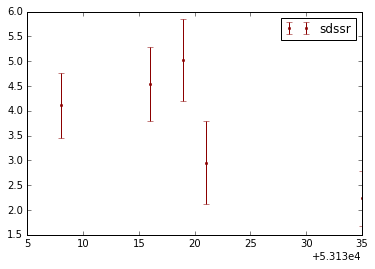

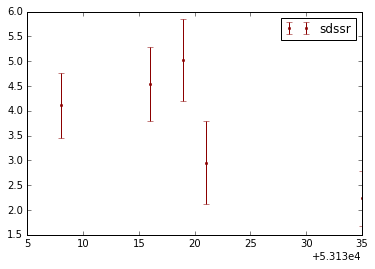

In [226]:
show_multi_filter_light_curve(copy_lcs[212], snls_colors)
plt.show()
show_multi_filter_light_curve(f_lcs[212], snls_colors)
plt.show()

In [132]:
fieldExps = []

for patch in patches:
    dId = {"filter":'r',"tract":0, "patch":patch, 'date':'2004-03-19'}
    if butler.datasetExists("dayDiff_differenceExp", dataId=dId):
        dexp = butler.get("dayDiff_differenceExp", dataId=dId)
        fieldExps.append(dexp)
       

In [143]:
snls_array = DSTools.load_SNLS_SN()

In [217]:
sn_patches = []
for lc in snls_array:
    if np.mean(lc["mjd"])>53080 and np.mean(lc["mjd"])<53204:
        for patch, dexp in zip(patches, fieldExps):
            wcs = dexp.getWcs()
            bbox = dexp.getBBox()
            Ra = afwGeom.Angle(lc[0]["ra"], afwGeom.radians)
            Dec = afwGeom.Angle(lc[0]["dec"], afwGeom.radians)
            coord = afwGeom.Point2I(wcs.skyToPixel(Ra,Dec))
            if bbox.contains(coord):
                sn_patches.append(patch)

In [218]:
sn_patches

['12,17',
 '13,15',
 '13,5',
 '13,6',
 '11,22',
 '11,23',
 '11,15',
 '12,13',
 '13,11',
 '9,15',
 '9,16',
 '10,13',
 '10,14',
 '10,22',
 '11,20',
 '0,10',
 '1,5',
 '1,16']

In [179]:
for patch, dexp in zip(patches, fieldExps):
    print patch, dexp

In [182]:
patches

[]

In [158]:
a = afwGeom.coordinates

In [210]:
snls_array[0]["mjd"]

52721.54
52721.59
52723.6
52730.44
52730.49
52753.55
52755.48
52758.44
52759.46
52792.35
52792.39


In [209]:
mjds_dict

{53080.0: '2004-03-16',
 53081.0: '2004-03-17',
 53083.0: '2004-03-19',
 53094.0: '2004-03-30',
 53109.0: '2004-04-14',
 53112.0: '2004-04-17',
 53116.0: '2004-04-21',
 53117.0: '2004-04-22',
 53121.0: '2004-04-26',
 53123.0: '2004-04-28',
 53134.0: '2004-05-09',
 53138.0: '2004-05-13',
 53146.0: '2004-05-21',
 53149.0: '2004-05-24',
 53151.0: '2004-05-26',
 53165.0: '2004-06-09',
 53169.0: '2004-06-13',
 53175.0: '2004-06-19',
 53177.0: '2004-06-21',
 53178.0: '2004-06-22',
 53182.0: '2004-06-26',
 53193.0: '2004-07-07',
 53195.0: '2004-07-09',
 53197.0: '2004-07-11',
 53198.0: '2004-07-12',
 53200.0: '2004-07-14',
 53202.0: '2004-07-16',
 53204.0: '2004-07-18'}